In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torchsummary import summary

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
def summarize_diagnostics(history):
    """
    Функция для отрисовки значений LOSS и ACCURACY на каждой эпохе
    """
    fig,ax=plt.subplots(2)
    fig.suptitle("Loss")
    fig.tight_layout()
    # plot loss
    ax[0].set_title('Log Loss')
    ax[0].plot(history['train_loss'], color='blue', label='Training loss')
    ax[0].plot(history['test_loss'], color='orange', label='validation loss')
    ax[0].legend(loc='best', shadow=True)
    # plot accuracy
    ax[1].set_title('Classification Accuracy')
    ax[1].plot(history['train_acc'], color='blue', label='train')
    ax[1].plot(history['test_acc'], color='orange', label='test')
    ax[1].legend(loc='best', shadow=True)

In [3]:
def imshow(inp, title=None):
    """Отображаем батч картинок. Лучше всего печатать по 8 картинок. Так нагляднее."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
# Это вручную написанный hinge loss. Позаимствовал отсюда https://www.datasciencebase.com/supervised-ml/algorithms/support-vector-machines/pytorch-example/
# Я очень долго пытался реализовать SVM через имеющийся в Pytorch HingeEmbeddingLoss. Но у меня ничего не получилось.
# При использовании HingeEmbeddingLoss у меня LOSS уходил в глубоко отрицательные значения и ACCURACY был равен нулю.
# Почему так вышло я не понял.
# Функция, реализованная ниже работает адекватно (хотя вроде как это то же самое, что HingeEmbeddingLoss, если верить документации)
def hinge_loss(y_pred, y_true):
    return torch.mean(torch.clamp(1 - y_true * y_pred, min=0))

In [23]:
def train_model(model, criterion, optimizer, scheduler, dataloaders=None, num_epochs=10, isLogreg=False, isSVM=False):
    """
    Функция для обучения нейронной сети.

    model - архитектура НС
    criterion - функция ошибки
    optimizer - вид градиентного спуска (SGD, Momentum, Adam)
    sheduler - объект, позволяющий итеративно изменять градиентный шаг
    num_epochs - число эпох
    """
    since = time.time()
    # Создаем словарь промежуточных статистик, чтобы считать качество на каждой эпохе
    dict_stat = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Ставим train-mode на тренировочной выборке. Есть операции, которые необходимо делать только во время обучения (например, DropOut), а на этапе валидации их считать не надо. https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
                else:
                    model.eval()   # Ставим eval-mode на тестовой выборке

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:

                    inputs = inputs.cuda() #.to(device=cuda)
                    inputs = inputs.to(torch.float32)

                    labels = labels.cuda() #.to(device=cuda)
                    labels = labels.to(torch.float32)

                    # Обнуляем вектор градиентов
                    # Вот здесь описано зачем мы это делаем: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
                    # И здесь: https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    # Для чего нужен torch.set_grad_enabled:
                    # https://discuss.pytorch.org/t/why-we-need-torch-set-grad-enabled-false-here/41240
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)

                        # Устанавливаю treshold на уровне 0.6. Если вероятность принадлежности классу 1 больше 0.6, то относим объект к классу 1 (REAL)
                        if isLogreg:
                            outputs = outputs.squeeze()
                            # Можно поиграть с treshold. Конкретно этот показывает неплохой ACCURACY
                            preds = (outputs > 0.6).int().reshape(-1)
                        elif isSVM:
                            outputs = outputs.squeeze()
                            margin = outputs * labels # (X, w) * Y
                            # Можно поиграть с treshold. Конкретно этот показывает неплохой ACCURACY
                            preds = (margin > 0).int().reshape(-1)
                            
                        # Внутри любой функции Loss'а есть параметр reduction. Он отвечает за усреднение лосса по батчу.
                        if isLogreg:
                            loss = criterion(outputs, labels)
                        elif isSVM:
                            # Если в качестве criterion задать HingeEmbeddingLoss и прописать в строке ниже criterion(outputs, labels), то градиентный не будет корректно работать. LOSS будет стремиться к -inf.
                            loss = hinge_loss(outputs, labels)

                        # backward + optimize только на стадии обучения НС
                        if phase == 'train':
                            # Считаем вектор градиентов
                            loss.backward()
                            # Делаем градиентный шаг
                            optimizer.step()

                    # Считаем статистики
                    # За каждую эпоху мы должны считать средний loss и accuracy по всем объектам.
                    # Мы умножаем loss на размер батча для корректности расчета средней оценки, 
                    # потому что может сложиться так, что в последний батч не попало заданное число объектов и поэтому было бы неправильно в дальнейшем делить суммарный loss на мощность всей выборки (epoch_loss = running_loss / dataset_sizes[phase])
                    # https://discuss.pytorch.org/t/confused-about-set-grad-enabled/38417
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                # Заносим статистики в словарь
                dict_stat[f'{phase}_loss'].append(epoch_loss)
                dict_stat[f'{phase}_acc'].append(epoch_acc.item())

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Сохраняем отдельно модель, которая дала лучшую accuracy
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        #model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, dict_stat

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
data_dir = "../data/cifake-real-and-ai-generated-synthetic-images"
image_datasets_logreg = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                                 data_transforms[x]
                                                 ) for x in ['train', 'test']}
# В документации написано, что если юзаешь CUDA, то необходимо выставлять pin_memory=True. Якобы так быстрее.
# https://pytorch.org/docs/stable/data.html
dataloaders_logreg = {x: torch.utils.data.DataLoader(image_datasets_logreg[x], batch_size=512,
                                             shuffle=True, num_workers=0, pin_memory=True)
                for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets_logreg[x]) for x in ['train', 'test']}
class_names = image_datasets_logreg['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device!")

Using cuda:0 device!


In [8]:
# Я вставил это сюда, потому что у меня долгое время не использовался GPU при доступной CUDA. Искал решение. 

# https://pytorch.org/docs/stable/notes/cuda.html
# The flag below controls whether to allow TF32 on matmul. This flag defaults to False
# in PyTorch 1.12 and later.
#torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
#torch.backends.cudnn.allow_tf32 = True

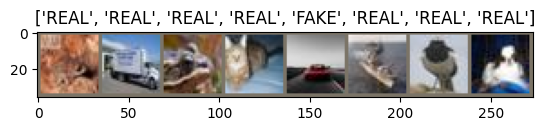

In [9]:
# отдельный DATALOADER для отрисовки, чтобы было удобнее
dataloaders_show = {x: torch.utils.data.DataLoader(image_datasets_logreg[x], batch_size=8,
                                                   shuffle=True, num_workers=0, pin_memory=True)
                                                   for x in ['train', 'test']}

# Get a batch of training data
inputs, classes = next(iter(dataloaders_show['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

[Отличное объяснение того, в чем разница между transfer_learning и fine_tuning](https://cs231n.github.io/transfer-learning/).

# ResNet18 (Feature Extractor) + LogReg

In [10]:
model_logreg = models.resnet18(weights='IMAGENET1K_V1')
# Фиксируем все параметры нейронной сети. Будем настраивать параметры только в fc-слое
for param in model_logreg.parameters():
    param.requires_grad = False

num_ftrs = model_logreg.fc.in_features
# Признаки, извлеченные из сверточных слоев пускаем на вход линейной модели
# nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid()) - это равносильно sigmoid(x), где x - линейная комбинация признаков
# На выходе мы получаем вероятность принадлежности объекта к классу REAL (поскольку LABEL(REAL) == 1)
model_logreg.fc = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid())

model_logreg = model_logreg.cuda() #.to(device=cuda)

# BCELoss - это обычный logloss. CrossEntropy для логистической регрессии использовать некорректно
criterion_logreg = torch.nn.BCELoss()

# Меняем параметры только для fc-слоя
optimizer_logreg = optim.SGD(model_logreg.fc.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)

# Итеративное изменение градиентного шага. Прикольная вещь. Чем дольше мы обучаемся, тем по идее мы должны быть ближе к минимуму.
# А чем ближе к минимуму, тем меньший размер шагов мы должны делать, чтобы его случайно не перескочить и сойтись в нем.
# Итеративное изменения шага помогает это сделать
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_logreg, step_size=7, gamma=0.1)

In [11]:
# Обучаем модель
model_inf, dict_stat = train_model(model_logreg, 
                                   criterion_logreg, 
                                   optimizer_logreg, 
                                   exp_lr_scheduler, 
                                   dataloaders=dataloaders_logreg, 
                                   num_epochs=20,
                                   isLogreg=True)

Epoch 0/19
----------
train Loss: 0.5220 Acc: 0.7339
test Loss: 0.4919 Acc: 0.7515

Epoch 1/19
----------
train Loss: 0.4928 Acc: 0.7552
test Loss: 0.4913 Acc: 0.7619

Epoch 2/19
----------
train Loss: 0.4934 Acc: 0.7560
test Loss: 0.5319 Acc: 0.7599

Epoch 3/19
----------
train Loss: 0.4915 Acc: 0.7587
test Loss: 0.4884 Acc: 0.7511

Epoch 4/19
----------
train Loss: 0.4881 Acc: 0.7592
test Loss: 0.4870 Acc: 0.7619

Epoch 5/19
----------
train Loss: 0.4889 Acc: 0.7594
test Loss: 0.4912 Acc: 0.7488

Epoch 6/19
----------
train Loss: 0.4883 Acc: 0.7589
test Loss: 0.4897 Acc: 0.7661

Epoch 7/19
----------
train Loss: 0.4807 Acc: 0.7641
test Loss: 0.4840 Acc: 0.7596

Epoch 8/19
----------
train Loss: 0.4794 Acc: 0.7634
test Loss: 0.4860 Acc: 0.7677

Epoch 9/19
----------
train Loss: 0.4797 Acc: 0.7644
test Loss: 0.4826 Acc: 0.7641

Epoch 10/19
----------
train Loss: 0.4800 Acc: 0.7653
test Loss: 0.4837 Acc: 0.7670

Epoch 11/19
----------
train Loss: 0.4793 Acc: 0.7641
test Loss: 0.4842 Acc

In [12]:
# Это нужно было для отладки
# i = 0
# for inputs, labels in dataloaders['test']:
#     i += 1
#     if i == 4:
#         break
#     inputs = inputs.to(device=cuda)
#     labels = labels.to(device=cuda)
#     outputs = model_inf(inputs)
#     #_, predictions = torch.max(outputs, 1)
#     predictions = outputs

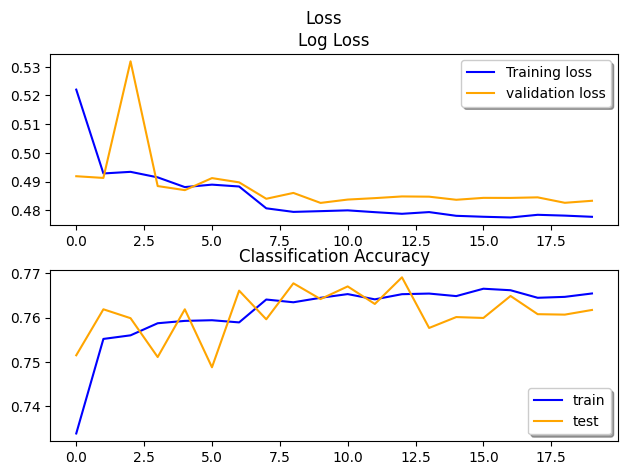

In [13]:
summarize_diagnostics(dict_stat)

Полный список претрейн моделей, доступных для трансфера из PyTorch: https://pytorch.org/vision/main/models.html

# ResNet18 (Feature Extractor) + SVM
Для реализации SVM мы воспользуемся Hinge Loss в качестве функции потерь.

Также необходимо перемэппить target из {0, 1} в {-1, 1} для корректной работы Hinge Loss.

In [14]:
class TargetMapper:
    def __init__(self, labels):
        self.labels_dict = {v: -1 if v=='REAL' else 1 for k, v in enumerate(labels)}
        self.labels_list = sorted(labels)

    def __call__(self, target):
        return self.labels_dict[self.labels_list[target]]

In [15]:
image_datasets_svm = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x],
                                              target_transform=TargetMapper(["REAL", "FAKE"]) # Трансформируем значения меток классов для SVM
                                              ) for x in ['train', 'test']}
# В документации написано, что если юзаешь CUDA, то необходимо выставлять pin_memory=True. Якобы так быстрее.
# https://pytorch.org/docs/stable/data.html
dataloaders_svm = {x: torch.utils.data.DataLoader(image_datasets_svm[x], batch_size=512,
                                                  shuffle=True, num_workers=0, pin_memory=True)
                for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets_svm[x]) for x in ['train', 'test']}
class_names = image_datasets_svm['train'].classes

In [24]:
model_svm = models.resnet18(weights='IMAGENET1K_V1')
# Фиксируем все параметры нейронной сети. Будем настраивать параметры только в fc-слое
for param in model_svm.parameters():
    param.requires_grad = False

num_ftrs = model_svm.fc.in_features
# Признаки, извлеченные из сверточных слоев пускаем на вход линейной модели
model_svm.fc = nn.Sequential(nn.Linear(num_ftrs, 1))

model_svm = model_svm.cuda() #.to(device=cuda)

# HingeEmbeddingLoss - это LOSS используемый для SVM
criterion_svm = torch.nn.HingeEmbeddingLoss()

# Меняем параметры только для fc-слоя
optimizer_svm = optim.SGD(model_svm.fc.parameters(), lr=0.01, momentum=0.7, weight_decay=0.01)

# Итеративное изменение градиентного шага. Прикольная вещь. Чем дольше мы обучаемся, тем по идее мы должны быть ближе к минимуму.
# А чем ближе к минимуму, тем меньший размер шагов мы должны делать, чтобы его случайно не перескочить и сойтись в нем.
# Итеративное изменения шага помогает это сделать
exp_lr_scheduler_svm = lr_scheduler.StepLR(optimizer_svm, step_size=7, gamma=0.1)

In [27]:
# Обучаем модель
model_inf_svm, dict_stat_svm = train_model(model_svm, 
                                           criterion_svm, 
                                           optimizer_svm, 
                                           exp_lr_scheduler_svm, 
                                           dataloaders=dataloaders_svm, 
                                           num_epochs=20,
                                           isSVM=True)

Epoch 0/19
----------
train Loss: 0.5555 Acc: 0.3810
test Loss: 0.5580 Acc: 0.3548

Epoch 1/19
----------
train Loss: 0.5522 Acc: 0.3819
test Loss: 0.5646 Acc: 0.3428

Epoch 2/19
----------
train Loss: 0.5398 Acc: 0.3840
test Loss: 0.5485 Acc: 0.3848

Epoch 3/19
----------
train Loss: 0.5396 Acc: 0.3848
test Loss: 0.5482 Acc: 0.3731

Epoch 4/19
----------
train Loss: 0.5394 Acc: 0.3839
test Loss: 0.5478 Acc: 0.3893

Epoch 5/19
----------
train Loss: 0.5392 Acc: 0.3852
test Loss: 0.5464 Acc: 0.3767

Epoch 6/19
----------
train Loss: 0.5400 Acc: 0.3838
test Loss: 0.5495 Acc: 0.3891

Epoch 7/19
----------
train Loss: 0.5384 Acc: 0.3859
test Loss: 0.5473 Acc: 0.3669

Epoch 8/19
----------
train Loss: 0.5398 Acc: 0.3833
test Loss: 0.5482 Acc: 0.3889

Epoch 9/19
----------
train Loss: 0.5387 Acc: 0.3859
test Loss: 0.5476 Acc: 0.3784

Epoch 10/19
----------
train Loss: 0.5372 Acc: 0.3853
test Loss: 0.5468 Acc: 0.3765

Epoch 11/19
----------
train Loss: 0.5382 Acc: 0.3844
test Loss: 0.5460 Acc

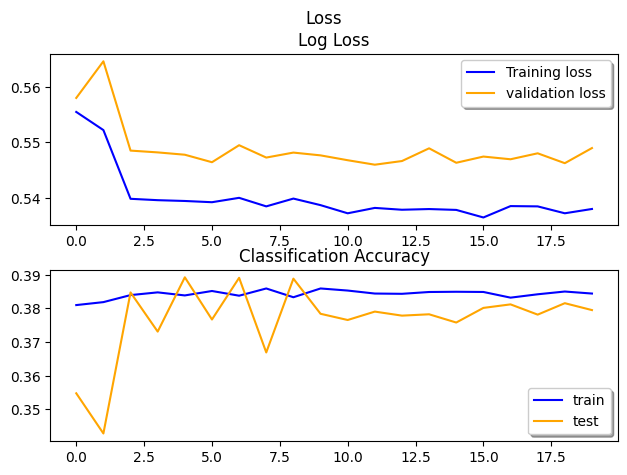

In [28]:
summarize_diagnostics(dict_stat_svm)

In [21]:
# Способ вывести все имеющиеся у объекта методы: 
# https://stackoverflow.com/questions/34439/finding-what-methods-a-python-object-has
resnet18 = models.resnet18(weights='IMAGENET1K_V1')

object_methods = [method_name for method_name in dir(resnet18)
                  if callable(getattr(resnet18, method_name))]

object_methods

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_apply',
 '_call_impl',
 '_forward_impl',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_make_layer',
 '_maybe_warn_non_full_backward_hook',
 '_named_members',
 '_norm_layer',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_wrapped_call_impl',
 'add_module',
 'apply',
 'avgpool',
 'bfloat16',
 'bn1',
 'buffers',
 'children',
 'compile',
 'conv1',
 'cpu',
 'cuda',
 'double',
 'eval',
 'extra_repr',
 'fc',
 'float',
 'forward',
 'get_buffer',
 'get_extra_state',
 'get_par

Тест GPU

In [ ]:
ac = torch.randn(10000, 10000).to(device)
bc = torch.randn(10000, 10000).to(device)
%time cc = torch.matmul(ac, bc)

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
ac = torch.randn(10000, 10000)#.to(device)
bc = torch.randn(10000, 10000)#.to(device)
%time cc = torch.matmul(ac, bc)

CPU times: total: 23.9 s
Wall time: 4.04 s


In [ ]:
#!nvidia-smi